# **Multiclass Text Classification - PyTorch**

> [**UCI ML Drug Review Dataset**](https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018)

In [ ]:
# Install Kaggle.
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Files Upload.
from google.colab import files

files.upload()

In [3]:
# Create a Kaggle Folder.
!mkdir ~/.kaggle

# Copy the kaggle.json to the folder created.
!cp kaggle.json ~/.kaggle/

# Permission for the json file to act.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset Download.
!kaggle datasets download -d jessicali9530/kuc-hackathon-winter-2018
!kaggle datasets download -d takuok/glove840b300dtxt

In [ ]:
# Unzip Dataset.
!unzip kuc-hackathon-winter-2018.zip
!unzip glove840b300dtxt.zip

In [ ]:
!pip install scikit-plot

In [7]:
# Import Library.
import pandas as pd
import numpy as np
import re, string, time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import warnings

warnings.filterwarnings("ignore")


# Basic Parameters.
EMBEDDED_SIZE = 300
MAX_FEATURES = 120000
MAX_LEN = 756
BATCH_SIZE = 64
N_EPOCHS = 10
debug = 0


# Load Dataset.
train_df = pd.read_csv("drugsComTrain_raw.csv")
test_df = pd.read_csv("drugsComTest_raw.csv")

data = pd.concat([train_df, test_df])[["review", "condition"]]
data.head()

,review,condition
0,"""It has no side effect, I take it in combinati...",Left Ventricular Dysfunction
1,"""My son is halfway through his fourth week of ...",ADHD
2,"""I used to take another oral contraceptive, wh...",Birth Control
3,"""This is my first time using any form of birth...",Birth Control
4,"""Suboxone has completely turned my life around...",Opiate Dependence


In [8]:
# Remove NULL Values from Dataset.
data = data[pd.notnull(data["review"])]

# Select count of reviews more than 3000.
count_df = (
    data[["condition", "review"]]
    .groupby("condition")
    .aggregate({"review": "count"})
    .reset_index()
    .sort_values("review", ascending=False)
)
target_conditions = count_df[count_df["review"] > 3000]["condition"].values


def condition_parser(x):
    return x if x in target_conditions else "OTHERS"


data["condition"] = data["condition"].apply(lambda x: condition_parser(x))
data = data[data["condition"] != "OTHERS"]

data["condition"].value_counts()

Birth Control              38436
Depression                 12164
Pain                        8245
Anxiety                     7812
Acne                        7435
Bipolar Disorde             5604
Insomnia                    4904
Weight Loss                 4857
Obesity                     4757
ADHD                        4509
Diabetes, Type 2            3362
Emergency Contraception     3290
High Blood Pressure         3104
Vaginal Yeast Infection     3085
Name: condition, dtype: int64

In [9]:
# Text Preprocessing & Cleaning.
def clean_review_text(text):
    text = text.lower()  # Convert text to lowercase.
    text = re.sub("<.*?>", "", text).strip()  # Remove HTML chars.
    text = text.translate(
        str.maketrans("", "", string.punctuation)
    )  # Remove punctuation marks.
    text = re.sub("(\\W)", " ", text).strip()  # Remove NON-ASCII chars.
    text = re.sub("\S*\d\S*\s*", "", text).strip()  # Remove words containing numbers.
    return text.strip()


# Apply Text Preprocessing.
data.review = data.review.astype(str)
data.review = data.review.apply(clean_review_text)

# Split Dataset into Training and Test Set.
X_train, X_test, y_train, y_test = train_test_split(
    data["review"],
    data["condition"],
    stratify=data["condition"],
    test_size=0.25,
    random_state=42,
)

# Encode Class Feature.
le = LabelEncoder()
y_train = le.fit_transform(y_train.values)
y_test = le.transform(y_test.values)

# Tokenize the Sentences.
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad the Sentences.
X_train = pad_sequences(X_train, maxlen=MAX_LEN)
X_test = pad_sequences(X_test, maxlen=MAX_LEN)


# Load Embeddings.
def load_glove(word_index):
    EMBEDDING_FILE = "glove.840B.300d.txt"

    def get_coefs(word, *arr):
        return word, np.asarray(arr, dtype="float32")[:EMBEDDED_SIZE]

    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = -0.005838499, 0.48782197
    embed_size = all_embs.shape[1]
    nb_words = min(MAX_FEATURES, len(word_index) + 1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

    for word, i in word_index.items():
        if i >= MAX_FEATURES:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


embedding_matrix = (
    np.random.randn(MAX_FEATURES, EMBEDDED_SIZE)
    if debug
    else load_glove(tokenizer.word_index)
)


# Plot Training and Validation Loss Graph.
def plot_graph(epochs, train_loss, valid_loss):
    fig = plt.figure(figsize=(10, 5))
    plt.title("Train & Validation Loss")
    plt.plot(list(np.arange(epochs) + 1), train_loss, label="train")
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label="validation")
    plt.xlabel("Number of Epochs", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.legend(loc="best")

# **Pytorch Model - TextCNN**

In [10]:
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()
        filter_sizes = [1, 2, 3, 5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(MAX_FEATURES, EMBEDDED_SIZE)
        self.embedding.weight = nn.Parameter(
            torch.tensor(embedding_matrix, dtype=torch.float32)
        )
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList(
            [nn.Conv2d(1, num_filters, (K, EMBEDDED_SIZE)) for K in filter_sizes]
        )
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(len(filter_sizes) * num_filters, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        return self.fc1(x)


# Model Hyperparameters.
model = TextCNN()
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
)
model.cuda()

# Load train and test data in CUDA Memory.
x_tr = torch.tensor(X_train, dtype=torch.long).cuda()
y_tr = torch.tensor(y_train, dtype=torch.long).cuda()
x_cv = torch.tensor(X_test, dtype=torch.long).cuda()
y_cv = torch.tensor(y_test, dtype=torch.long).cuda()

# Create Torch Datasets.
train = torch.utils.data.TensorDataset(x_tr, y_tr)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders.
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # Set model to train configuration.
    model.train()
    avg_loss = 0.0

    for x_batch, y_batch in train_loader:
        # Forward Pass and Loss Computation.
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        # Backward Pass and Weight's Updation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration.
    model.eval()
    avg_val_loss = 0.0
    val_preds = np.zeros((len(x_cv), len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += criterion(y_pred, y_batch).item() / len(valid_loader)
        # Store Predictions.
        val_preds[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = (
            F.softmax(y_pred).cpu().numpy()
        )

    # Calculate Metrics.
    val_accuracy = sum(val_preds.argmax(axis=1) == y_test) / len(y_test)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time

    print(
        "Epoch {}/{} \t loss={:.3f} \t val_loss={:.3f} \t val_acc={:.3f} \t time={:.2f}s".format(
            epoch + 1, N_EPOCHS, avg_loss, avg_val_loss, val_accuracy, elapsed_time
        )
    )


# Save the entire TextCNN Model.
torch.save(model, "textCNN_model")

Epoch 1/10 	 loss=38.203 	 val_loss=25.302 	 val_acc=0.862 	 time=59.28s
Epoch 2/10 	 loss=25.332 	 val_loss=23.665 	 val_acc=0.868 	 time=62.91s
Epoch 3/10 	 loss=22.238 	 val_loss=22.675 	 val_acc=0.876 	 time=62.64s
Epoch 4/10 	 loss=19.919 	 val_loss=20.607 	 val_acc=0.887 	 time=62.64s
Epoch 5/10 	 loss=18.154 	 val_loss=21.125 	 val_acc=0.889 	 time=62.70s
Epoch 6/10 	 loss=16.701 	 val_loss=20.013 	 val_acc=0.894 	 time=62.70s
Epoch 7/10 	 loss=15.265 	 val_loss=19.768 	 val_acc=0.898 	 time=62.70s
Epoch 8/10 	 loss=14.119 	 val_loss=19.597 	 val_acc=0.899 	 time=62.75s
Epoch 9/10 	 loss=13.336 	 val_loss=18.977 	 val_acc=0.905 	 time=62.65s
Epoch 10/10 	 loss=12.426 	 val_loss=19.489 	 val_acc=0.906 	 time=62.67s


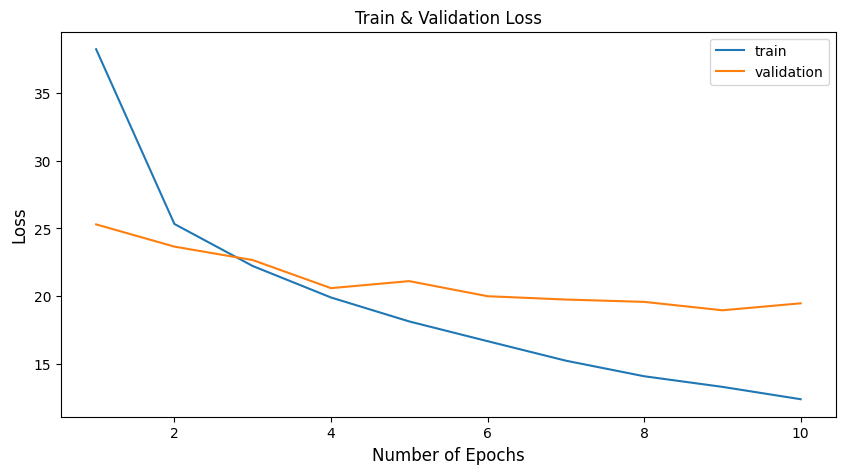

In [11]:
# Plot Graph.
plot_graph(N_EPOCHS, train_loss, valid_loss)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

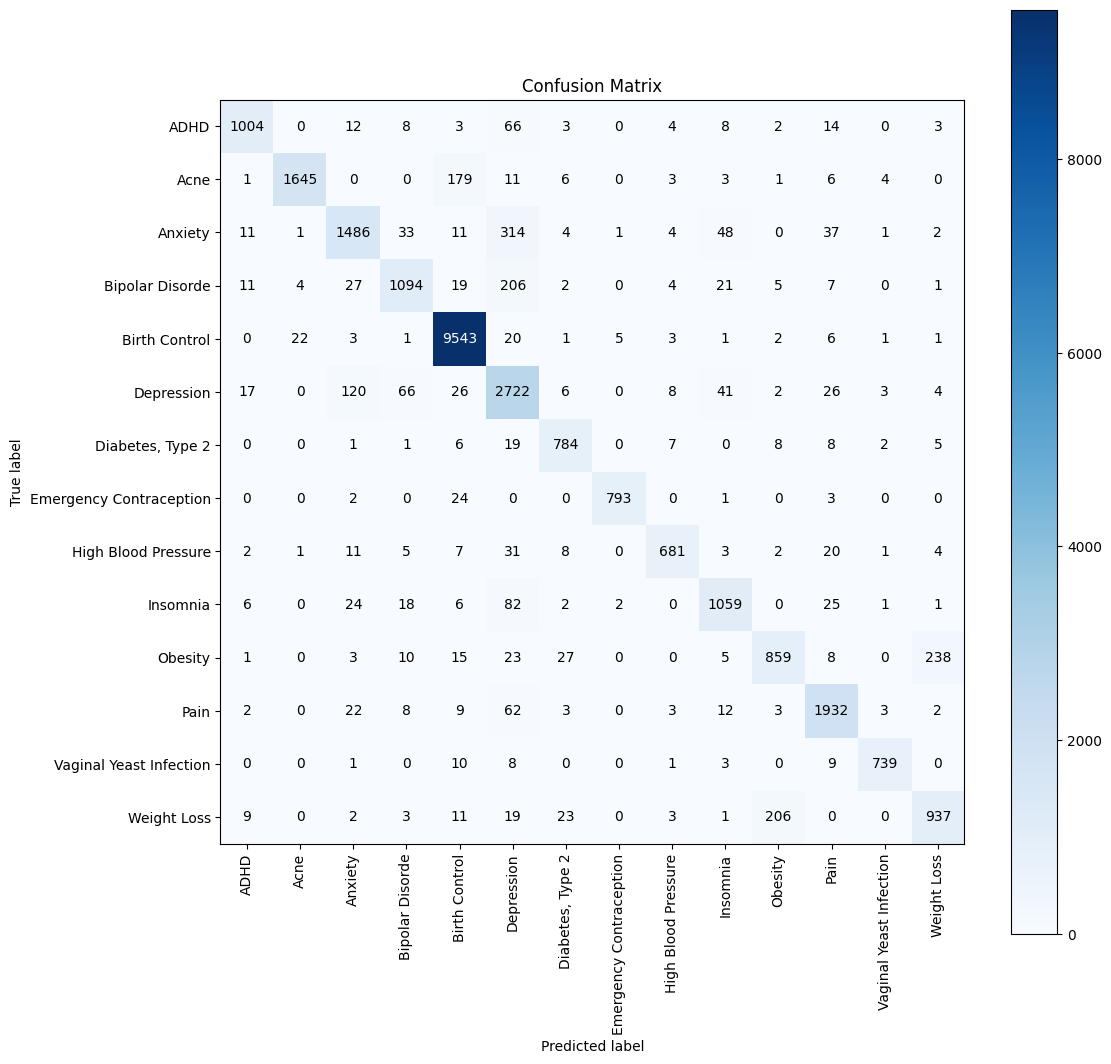

In [12]:
y_true = [le.classes_[x] for x in y_test]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, y_pred, figsize=(12, 12), x_tick_rotation=90
)

# **PyTorch Model - BiLSTM**

In [13]:
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(MAX_FEATURES, EMBEDDED_SIZE)
        self.embedding.weight = nn.Parameter(
            torch.tensor(embedding_matrix, dtype=torch.float32)
        )
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(
            EMBEDDED_SIZE, self.hidden_size, bidirectional=True, batch_first=True
        )
        self.linear = nn.Linear(self.hidden_size * 4, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, n_classes)

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out


# Model Hyperparameters.
model = BiLSTM()
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.001
)
model.cuda()

# Load train and test data in CUDA Memory.
x_tr = torch.tensor(X_train, dtype=torch.long).cuda()
y_tr = torch.tensor(y_train, dtype=torch.long).cuda()
x_cv = torch.tensor(X_test, dtype=torch.long).cuda()
y_cv = torch.tensor(y_test, dtype=torch.long).cuda()

# Create Torch Datasets.
train = torch.utils.data.TensorDataset(x_tr, y_tr)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders.
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # Set model to train configuration.
    model.train()
    avg_loss = 0.0

    for x_batch, y_batch in train_loader:
        # Forward Pass and Loss Computation.
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        # Backward Pass and Weight's Updation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Set model to validation configuration.
    model.eval()
    avg_val_loss = 0.0
    val_preds = np.zeros((len(x_cv), len(le.classes_)))

    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += criterion(y_pred, y_batch).item() / len(valid_loader)
        # Store Predictions.
        val_preds[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = (
            F.softmax(y_pred).cpu().numpy()
        )

    # Calculate Metrics.
    val_accuracy = sum(val_preds.argmax(axis=1) == y_test) / len(y_test)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time

    print(
        "Epoch {}/{} \t loss={:.3f} \t val_loss={:.3f} \t val_acc={:.3f} \t time={:.2f}s".format(
            epoch + 1, N_EPOCHS, avg_loss, avg_val_loss, val_accuracy, elapsed_time
        )
    )


# Save the entire BiLSTM Model.
torch.save(model, "BiLSTM_model")

Epoch 1/10 	 loss=55.288 	 val_loss=28.723 	 val_acc=0.846 	 time=35.87s
Epoch 2/10 	 loss=28.565 	 val_loss=25.822 	 val_acc=0.859 	 time=35.81s
Epoch 3/10 	 loss=24.488 	 val_loss=23.703 	 val_acc=0.870 	 time=35.85s
Epoch 4/10 	 loss=21.972 	 val_loss=22.260 	 val_acc=0.875 	 time=35.82s
Epoch 5/10 	 loss=19.769 	 val_loss=22.105 	 val_acc=0.879 	 time=35.80s
Epoch 6/10 	 loss=18.019 	 val_loss=21.056 	 val_acc=0.887 	 time=35.80s
Epoch 7/10 	 loss=16.350 	 val_loss=20.824 	 val_acc=0.891 	 time=35.83s
Epoch 8/10 	 loss=15.034 	 val_loss=20.315 	 val_acc=0.890 	 time=35.78s
Epoch 9/10 	 loss=13.711 	 val_loss=19.911 	 val_acc=0.898 	 time=35.73s
Epoch 10/10 	 loss=12.496 	 val_loss=19.828 	 val_acc=0.900 	 time=35.68s


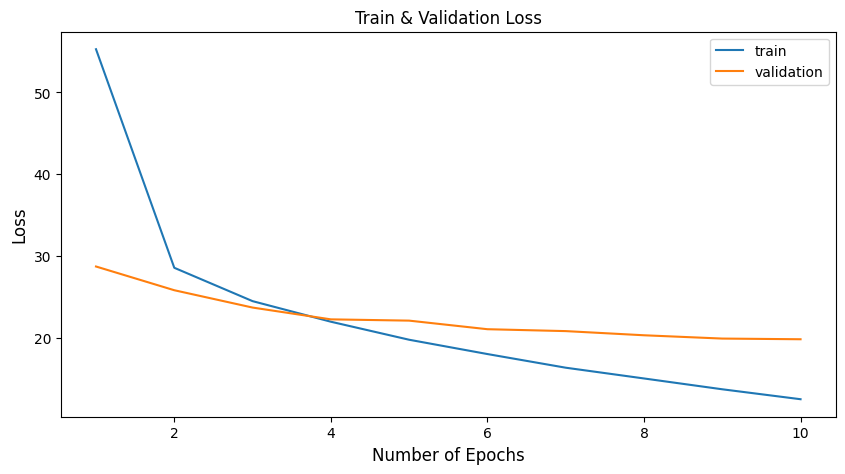

In [14]:
# Plot Graph.
plot_graph(N_EPOCHS, train_loss, valid_loss)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

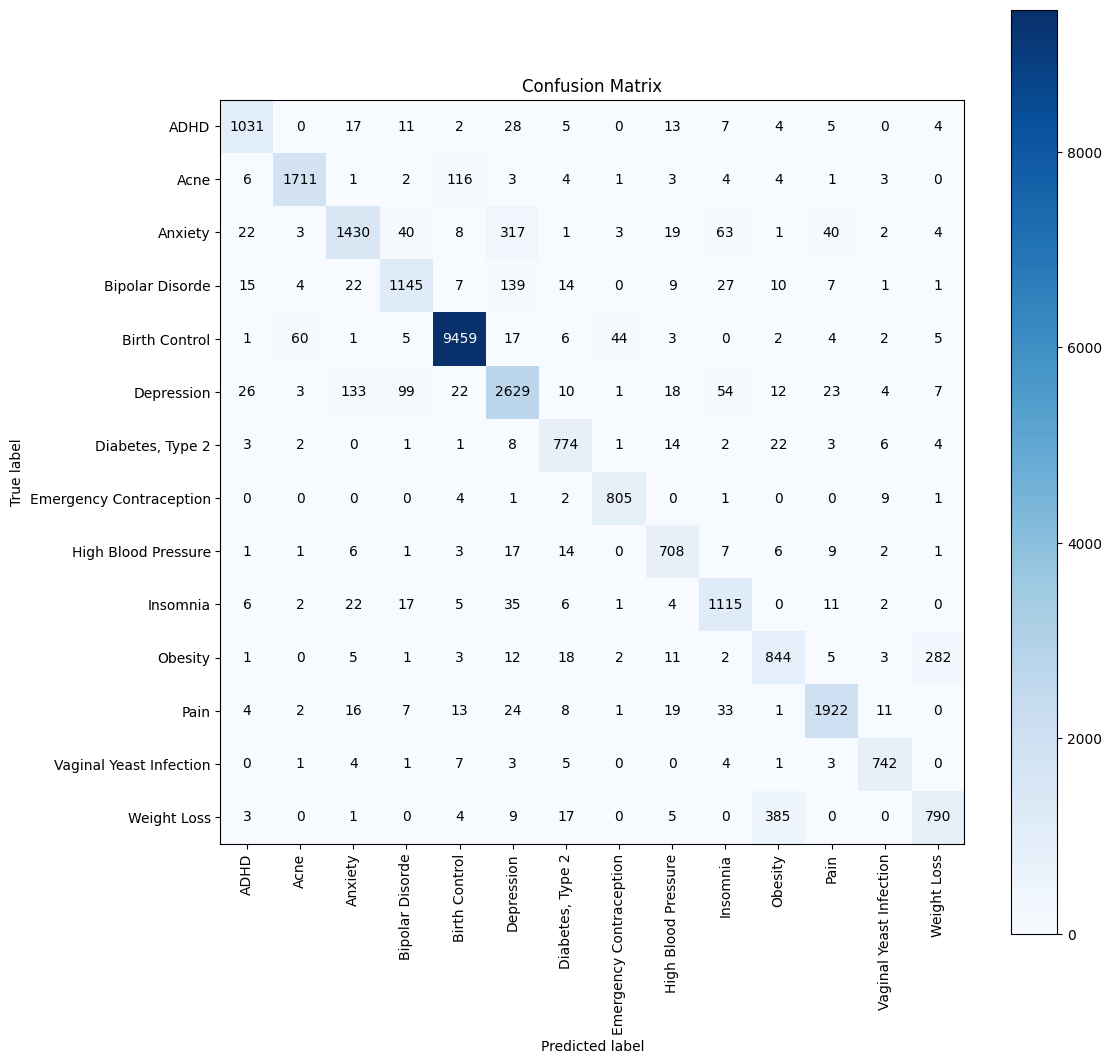

In [15]:
y_true = [le.classes_[x] for x in y_test]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, y_pred, figsize=(12, 12), x_tick_rotation=90
)

In [17]:
""" Predict A Single Example. """

# Load entire BiLSTM Model.
BiLSTM_model = torch.load("BiLSTM_model")
BiLSTM_model.eval()


# Predict a Single Sentence.
def predict_class(text, model=BiLSTM_model):
    text = text.lower()
    text = re.sub("!@#$%^&*?-_+=|':;/>.,<[{()}]", "", text).strip()
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=MAX_LEN)
    text = torch.tensor(text, dtype=torch.long).cuda()
    pred = model(text).detach()
    pred = F.softmax(pred).cpu().numpy()
    pred = pred.argmax(axis=1)
    pred = le.classes_[pred]
    return pred[0]


sentence = """ James is a 42-year-old male who owns his own construction company. He works in both the office, as well as on-site helping with his crew. 
               3 months ago, James began developing lower back pain (LBP). He denies an MOI and reports that it has become constant and has made his job 
               increasingly difficult. To control the pain, he has been taking frequent breaks during the workday to lie down in his truck but feels that 
               his crew is judging him for not pushing through the pain. He also reports that his pain has been preventing him from sleeping, which has 
               been affecting his ability to run his company. He was hoping that the pain would resolve on its own, but recently he has felt that he should 
               "just give up" on trying to get better. He is starting to find that he is always tired and reports that he “kind of doesn’t care if the business 
               fails”, because he believes working is the reason he is in pain. After a friend recommended him to PT, he decided that he would try anything 
               to make the pain go away, but he is unsure of how exercise will help him. James currently smokes half a pack of cigarettes a day and has no 
               outstanding past medical history. """

predict_class(sentence)

'High Blood Pressure'